# TP2 - Random variable generators
Eliott Van Dieren - epfl

In [21]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.special import erf
import math
import scipy.integrate as integrate
import scipy.special as special
import time
from random import randint

## 1. Inverse method

In [2]:
def F(x):
    if x < 0:
        return 0
    elif (x >= 2):
        return 1
    else:
        return 1-2/3*np.exp(-x/2)

def F_inv(x):
    return -2*np.log(3/2*(1-x))

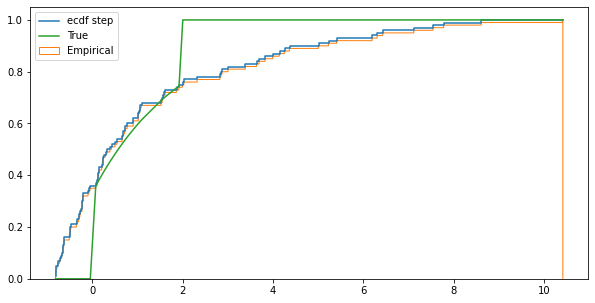

MSE 100 obs: 0.020892466910912236


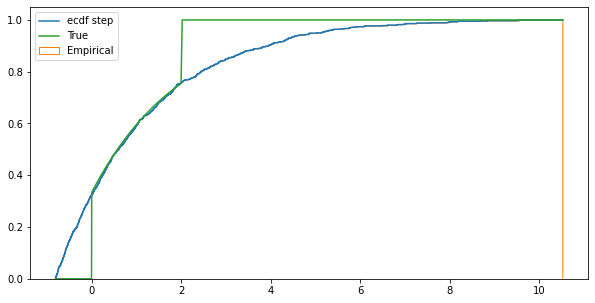

MSE 1000 obs: 0.015701961086025614


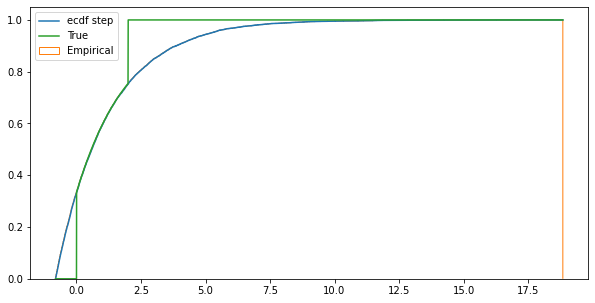

MSE 10000 obs: 0.01729457377245562


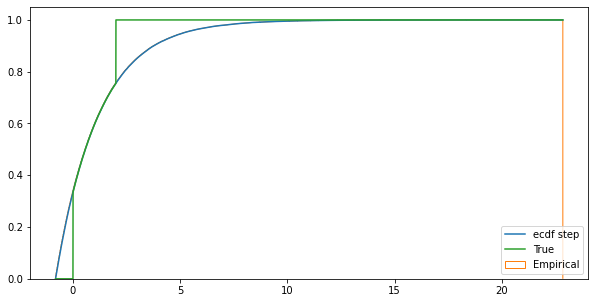

MSE 100000 obs: 0.017414834184960835


In [3]:
size = [100,1000,10000,100000]
for n in size:
    uni_sample = st.uniform.rvs(size=n)
    X = F_inv(uni_sample)
    Fx = [F(x) for x in np.sort(X)]
    ecdf = ECDF(X)
    fig,ax = plt.subplots(1,figsize=(10,5))
    ax.step(np.sort(X),ecdf(np.sort(X)),label="ecdf step")
    ax.hist(X,1000, density=True,histtype='step',cumulative=True, label='Empirical')
    ax.plot(np.sort(X),Fx,label="True")
    plt.legend()
    plt.show()
    print(f"MSE {n} obs:",np.sum((Fx-ecdf(np.sort(X)))**2)/len(X))

## 2. Acceptance Rejection

In [4]:
def f_tilde(x):
    return (np.sin(6*x)**2 + 3*(np.cos(x)**2)*np.sin(4*x)**2 + 1)*np.exp(-0.5*x**2)
def g(x):
    return np.exp(-0.5*x**2)/np.sqrt(2*np.pi)

In [5]:
C = 5*np.sqrt(2*np.pi) # by taking upper bounds of f_tilde

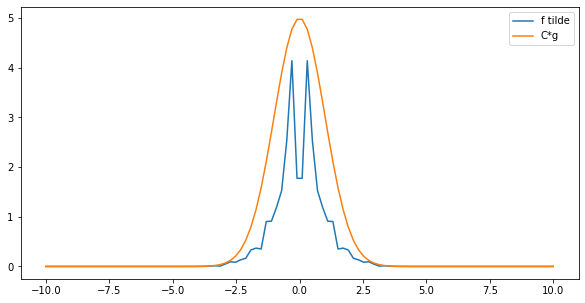

In [6]:
x = np.linspace(-10,10,100)
fig = plt.figure(figsize=(10,5))
plt.plot(x,f_tilde(x),label="f tilde")
plt.plot(x,C*g(x),label="C*g")
plt.legend()
plt.show()

In [7]:
n = 10**4
X_accepted = np.zeros(n)
count = 0
total_trials = 0
while (count < n): 
    total_trials += 1
    Y = st.norm.rvs()
    U = st.uniform.rvs()
    if U*C*g(Y)<=f_tilde(Y):
        X_accepted[count] = Y
        count += 1

In [8]:
approx_prob = n/total_trials
print(approx_prob)

0.4671587405400355


In [9]:
kappa_approx = 1/(C*approx_prob)
print("err :",np.abs(kappa_approx-0.1696542774))

err : 0.001140891685461387


In [10]:
ecdf_accept = ECDF(X_accepted)

In [11]:
def e(x):
    return math.exp(x)
#Defines the PDF
def theor_pdf(x):
    f= (np.sin(6*x)**2+3*np.cos(x)**2*np.sin(4*x)**2+1)*np.exp(-x**2/2)
    mass=(-4-3*e(22)-6*e(40)-3*e(54)+6*e(70)+18*e(72))*math.sqrt(math.pi*0.5)/(4*e(72))
    return f/mass;
#Computes the CDF
def theor_cdf(x):
    f=integrate.quad(theor_pdf, -10, x)[0]
    return f

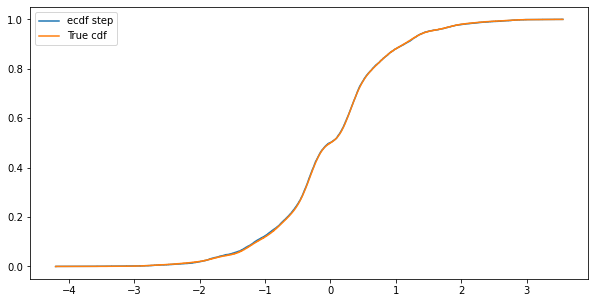

In [12]:
fig,ax = plt.subplots(1,figsize=(10,5))
X_plot = np.sort(X_accepted)
true_cdf = [theor_cdf(x) for x in X_plot]
ax.step(X_plot,ecdf_accept(X_plot),label="ecdf step")
ax.step(X_plot,true_cdf,label="True cdf")
#ax.hist(X_accepted,1000, density=True,histtype='step',cumulative=True, label='Empirical')
plt.legend()
plt.show()
#print(f"MSE {n} obs:",np.sum((Fx-ecdf(np.sort(X)))**2)/len(X))

## 3. Polar coordinates

In [13]:
C = np.exp(0.5)*np.sqrt(2/np.pi)
def g(x):
    return np.exp(-np.abs(x))/2

# we can decompose np.exp(-np.abs(x))/2 as a sum of two exponentials

In [14]:
n = 10**4
X_accepted = np.zeros(n)
count = 0
total_trials = 0
start = time.time()
while (count < n):
    Y = (2*st.bernoulli.rvs(0.5)-1)*st.expon(scale=2).rvs()
    U = st.uniform.rvs()
    if U*C*g(Y)<=st.norm.pdf(Y):
        X_accepted[count] = Y
        count += 1
end = time.time()
print("ellapsed time: ",end-start)

ellapsed time:  15.080505132675171


In [15]:
# ---- Box-Muller method
# this is a very inefficient implementation of the BM algorithm
#as it not vectoized. However, we chose to do so in order to have a
# more fair comparison between A.R and B.M
start = time.time()
rho = np.sqrt(st.expon.rvs(scale=2,size=(n,)))
V = st.uniform.rvs(size = (n,))
theta = 2 * np.pi * V
X_bm = rho * np.cos(theta)
Y_bm = rho * np.sin(theta)
end = time.time()
print("ellapsed time: ",end-start)

ellapsed time:  0.0025510787963867188


## 4. Kernel density estimation

In [16]:
#Defines the KDE function
def kde(x, X):
    N = X.shape[0]
    delta = N**(-1/5)
    pdf = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        pdf[i] = np.sum(np.exp( - ((x[i]-X)/delta)** 2 / 2.) / np.sqrt(2*math.pi)) / (N*delta)
    return pdf

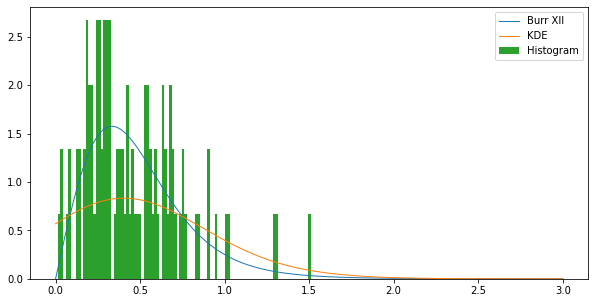

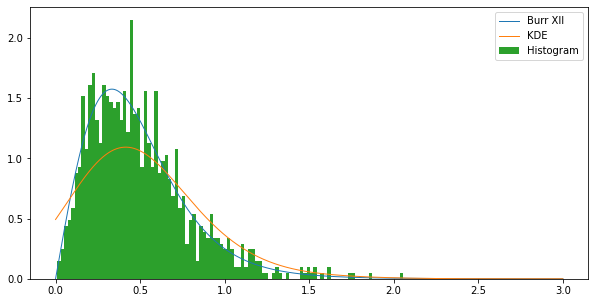

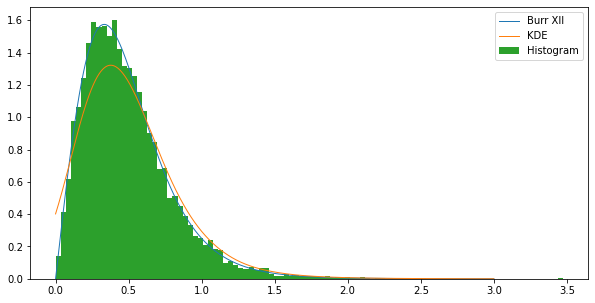

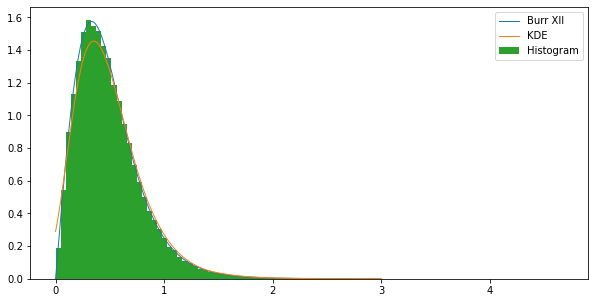

In [19]:
K = st.norm.pdf
for n in [100,1000,10000,10**5]:
    X_burr = st.burr12(c=2,d=4).rvs(size=n)
    x_plot = np.linspace(0, 3, 1001)
    fig = plt.figure(figsize=(10,5))
    plt.plot(x_plot, st.burr12(c=2,d=4).pdf(x_plot), linewidth = 1.)
    plt.plot(x_plot, kde(x_plot, X_burr), linewidth = 1.)
    plt.hist(X_burr, bins = 100, density = True)
    plt.legend(['Burr XII','KDE','Histogram'])
    plt.show()

Compute $Y^n_i$ ~ $f_n(x)$ for $i \in \{1,...,N\}$ with composition. Les éléments de la composition sont les K((x-xi)/delta) et on a une proba uniforme de les sélectionner

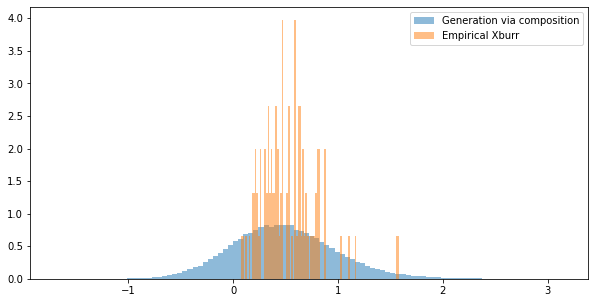

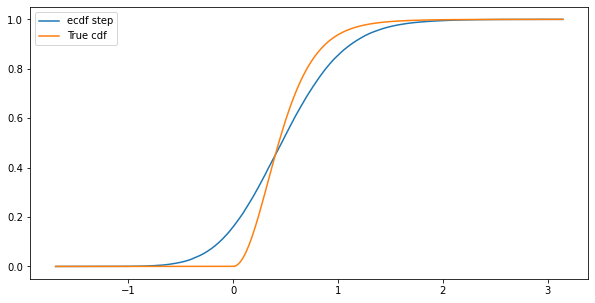

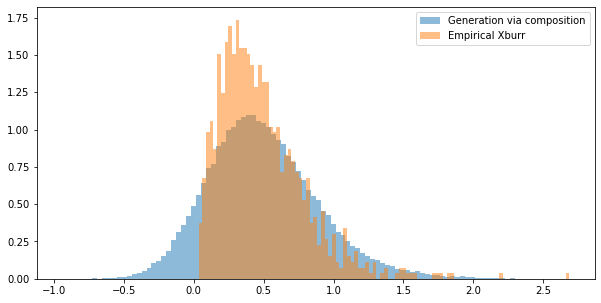

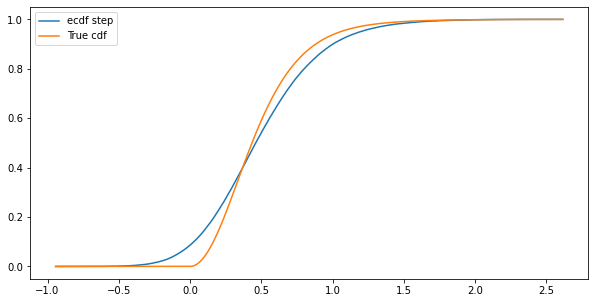

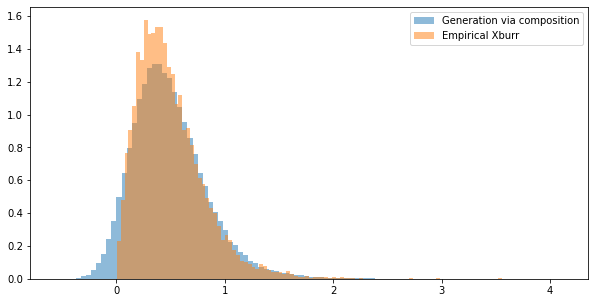

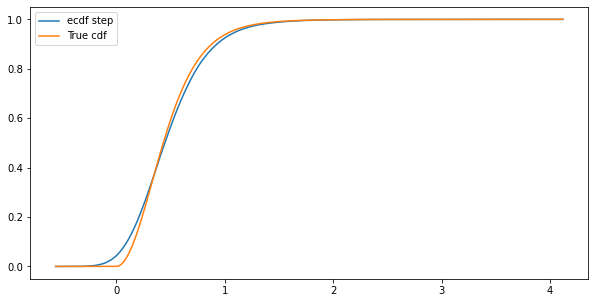

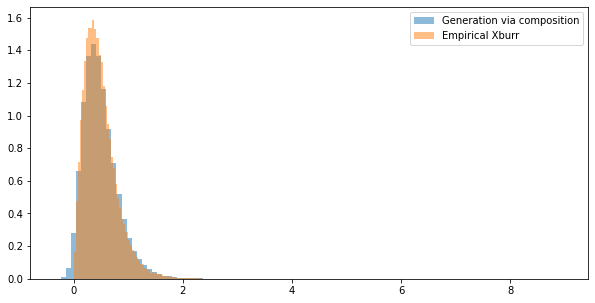

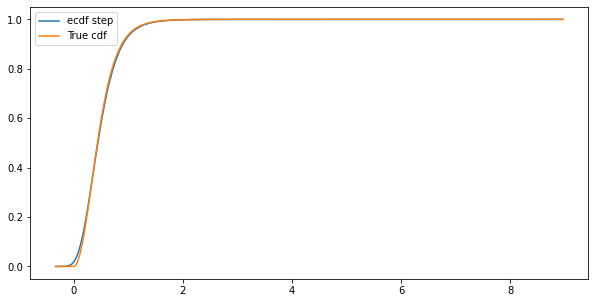

In [31]:
N = 10**5
D_n = np.zeros(4)
for idx,n in enumerate([100,1000,10000,10**5]):
    delta = n**(-1/5)
    Y = np.zeros(N)
    prob_pick = 1/n # uniform proba de selectionner K_delta
    X_burr = st.burr12(c=2,d=4).rvs(size=n)
    for i in range(len(Y)):
        index_Xi = randint(0,n-1)
        Xi = X_burr[index_Xi]
        Y[i] = st.norm.rvs(loc=Xi, scale=delta)
    X_burr = st.burr12(c=2,d=4).rvs(size=n)
    fig = plt.figure(figsize=(10,5))
    plt.hist(Y, bins = 100, density = True,alpha=0.5)
    plt.hist(X_burr,bins=100,density=True,alpha=0.5)
    plt.legend(['Generation via composition','Empirical Xburr'])
    plt.show()
    
    Y_ecdf = ECDF(Y)
    fig,ax = plt.subplots(1,figsize=(10,5))
    Y_plot = np.sort(Y)
    true_cdf = st.burr12.cdf(Y_plot, c=2, d=4)
    ax.step(Y_plot,Y_ecdf(Y_plot),label="ecdf step")
    ax.step(Y_plot,true_cdf,label="True cdf")
    
    D_n[idx] = np.max(np.abs(Y_ecdf(Y_plot)-true_cdf))
    plt.legend()
    plt.show()

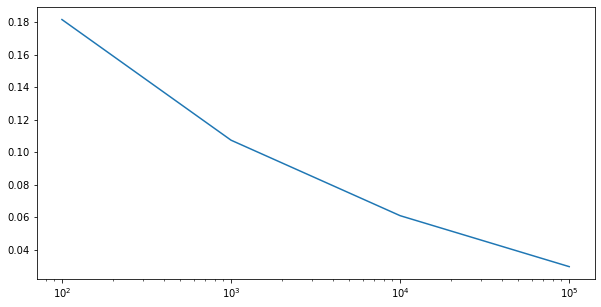

In [35]:
fig,ax = plt.subplots(1,figsize=(10,5))
ax.plot([100,1000,10000,10**5],D_n)
ax.set_xscale('log')
plt.show()

##  5. Cauchy Distribution

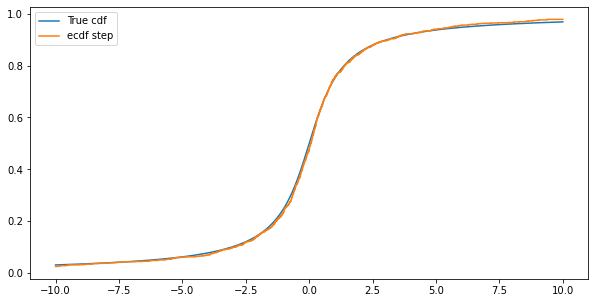

In [79]:
# Inverse method
n=1000
F = lambda x : np.arctan(x)/np.pi + 0.5
F_inv = lambda x : np.tan(np.pi*(x-0.5))
X = F_inv(st.uniform.rvs(size=n))
X_plot = np.linspace(-10,10,n)
fig,ax = plt.subplots(1,figsize=(10,5))
X_ecdf = ECDF(X)
ax.plot(X_plot,F(X_plot),label="True cdf")
ax.step(X_plot,X_ecdf(X_plot),label="ecdf step")
plt.legend()
plt.show()

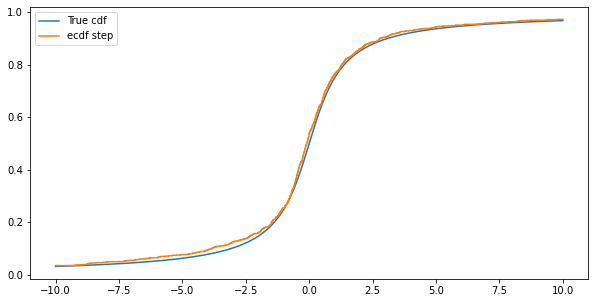

In [80]:
# Ratio of gaussians
X_1 = st.norm.rvs(size=n)
X_2 = st.norm.rvs(size=n)
X = X_1/X_2
X_plot = np.linspace(-10,10,n)
fig,ax = plt.subplots(1,figsize=(10,5))
X_ecdf = ECDF(X)
ax.plot(X_plot,F(X_plot),label="True cdf")
ax.step(X_plot,X_ecdf(X_plot),label="ecdf step")
plt.legend()
plt.show()